<a href="https://colab.research.google.com/github/xdderekchen/ML/blob/master/Test_API_IXINBUY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstation of Web API of ixinbuy.com

ixinbuy.com provides Web API for users to access the powerful block-chain based services.

This post has 2 purposes:
 1. Samples for API calls
 2. Testing of API and the webservice

## 1.1. Version 1

In this version, we will test the following 3 functions
 * **(POST)** http://ixinbuy.com/register
 * **(POST)** http://ixinbuy.com/uploaddata
 * **(GET)**  http://ixinbuy.com/getshareddata

### register

In [2]:
# http://ixinbuy.com/register

import requests
import json

URL = "http://ixinbuy.com/register"

DEVICE_ID = "XD_COVID19_V1"

payload = {"device_id":DEVICE_ID}

#Passing payload as dict
responce = requests.post(URL, data = payload)
print(responce.status_code)
print(responce.text)


#Passing payload as json string
#payload = '{"device_id":"XD12345"}'
#responce = requests.post(URL, json = json.loads(payload))
#print(responce.status_code)
#print(responce.text)

200
true


### uploaddata (single)

In [3]:
# http://ixinbuy.com/uploaddata

import requests
import json

URL = "http://ixinbuy.com/uploaddata"

# data_type": 2 for COVID19 data
payload = {
   "data_type": 2, 
   "device_id": DEVICE_ID,
   "device_data": {
          "date": "2020-01-07",
          "province_state": "Shanghai00",
          "country_region": "Mainland China",
          "last_update": "2020-03-07T10:43:02",
          "confirmed":100,
          "deaths": 7,
          "recovered": 1237,
          "latitude":  23.3417,
          "longitude": 113.4244
   }
}


#Passing payload as dict
responce = requests.post(URL, json = payload)
print(responce.status_code)
print(responce.text)


200
true


### Define a function to rename the columns with standard names.

In [26]:
import numpy as np

def transform_names(df):
    '''
       need to have standard names
    '''
    df.columns = [x.lower() for x in df.columns]
    df.rename(columns={'province/state': 'province_state',
                   'country/region': 'country_region',
                   'last update'   : 'last_update',
                   "long_":          "longitude",
                   "long":          "longitude",
                   "lat":           "latitude",
                   "lat_":           "latitude",
                  }, inplace=True)
    
    
    return (df)

##### Testing
def run_test(date= "03-20-2020"):
    github_root = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports"
    file = os.path.join(github_root, date + ".csv")
    df = pd.read_csv(file ,dtype = {'FIPS': str, 'ZIP': str, "ZIP_CODE": str})
    df = transform_names(df)
    print(df.columns)

    row = df.iloc[1]
    print(json.loads(row.to_json()))

run_test("03-20-2020")  #Old format
run_test("03-26-2020")  #new format


Index(['province_state', 'country_region', 'last_update', 'confirmed',
       'deaths', 'recovered', 'latitude', 'longitude'],
      dtype='object')
{'province_state': None, 'country_region': 'Italy', 'last_update': '2020-03-20T17:43:03', 'confirmed': 47021, 'deaths': 4032, 'recovered': 4440, 'latitude': 41.8719, 'longitude': 12.5674}
Index(['fips', 'admin2', 'province_state', 'country_region', 'last_update',
       'latitude', 'longitude', 'confirmed', 'deaths', 'recovered', 'active',
       'combined_key'],
      dtype='object')
{'fips': '22001', 'admin2': 'Acadia', 'province_state': 'Louisiana', 'country_region': 'US', 'last_update': '2020-03-26 23:48:35', 'latitude': 30.2950649, 'longitude': -92.41419698, 'confirmed': 3, 'deaths': 0, 'recovered': 0, 'active': 0, 'combined_key': 'Acadia, Louisiana, US'}


### uploaddata (batch)

In here, we will pull real data from John Hopkins and invoke the webservice call.

The data of John Hopkins is at "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports"
    

In [0]:
import pandas as pd
import os
import requests
import json

def uploaddata(source_file, URL, data_date):
    print("processing: ", source_file)
    df = pd.read_csv(source_file, dtype = {'FIPS': str, 'ZIP': str, "ZIP_CODE": str})
    df = transform_names(df)
    for i in range(0, df.shape[0])  :####df.itertuples(index=False):
      
        row = df.iloc[i]
        #row_as_dic = row.to_dict()
       
        device_data = {"date":data_date }
        device_data.update(json.loads(row.to_json()))
       
        payload = {
           "data_type": 2, 
           "device_id": DEVICE_ID,
           "device_data": device_data
        }

        print(payload)
        responce = requests.post(URL, json = payload)
        errorCount = 0
        
        if (responce.status_code == 200) and ( responce.text == "true"):
           if (i % 10==0):
              print(i, "", end='', flush=True)
        else:
              errorCount += 1
              print("\nError ", i , " with ", responce.text, flush=True)

    print(f"\nProcessed {i+3} of records")
    return (errorCount)
      
       

github_root = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports"


file = os.path.join(github_root, "03-26-2020" + ".csv")

import time
ts = time.time()
d = uploaddata(file, "http://ixinbuy.com/uploaddata", "2020-03-26")
te = time.time()
print('%s  %2.2f sec' % ("uploaddata", (te - ts) ))
 


### getshareddata (GET)

This is the method to retrieve data from server



In [41]:
import pandas as pd
import os
import requests
import json

query = {"data_type": 2, "device_id":DEVICE_ID, "from_date": "2020-03-26"}

req = requests.get('http://ixinbuy.com/getshareddata', params=query)
print(req.url)
print(req.status_code)
print(req)
data = req.json()

df = pd.DataFrame(data)
#print(df)
#df = df[~df['country_region'].isin(["China000", "China111"])]
#df = df.drop_duplicates(subset=["country_region", "province_state", "date" ], keep='last')
#df = df.query('country_region=="Italy"')

df_agg=df.groupby(["country_region", "date"]).agg({'confirmed': ['sum'], 'deaths': ['sum'], 'recovered': ['sum']})
df_agg.columns = ['confirmed', 'deaths', 'recovered']
df_agg.reset_index(inplace=True)

df_agg["fatality_rate"] = df_agg["deaths"] / df_agg["confirmed"]

df_confirm = df_agg.sort_values(by='confirmed', ascending=False).head(120)

df_confirm

df[ (df["country_region"]=="US") & (df["province_state"] == "New York")]

http://ixinbuy.com/getshareddata?data_type=2&device_id=XD_COVID19_V1&from_date=2020-03-26
200
<Response [200]>


,date,fips,admin2,province_state,country_region,last_update,latitude,longitude,confirmed,deaths,recovered,active,combined_key
23,2020-03-26,36123,Yates,New York,US,2020-03-26 23:48:35,42.635055,-77.103699,0,0,0,0,"Yates, New York, US"


#### visualization

Text(0.5, 1.0, 'Fatality Rate, for top 20 countries by the number of confirmed cases')

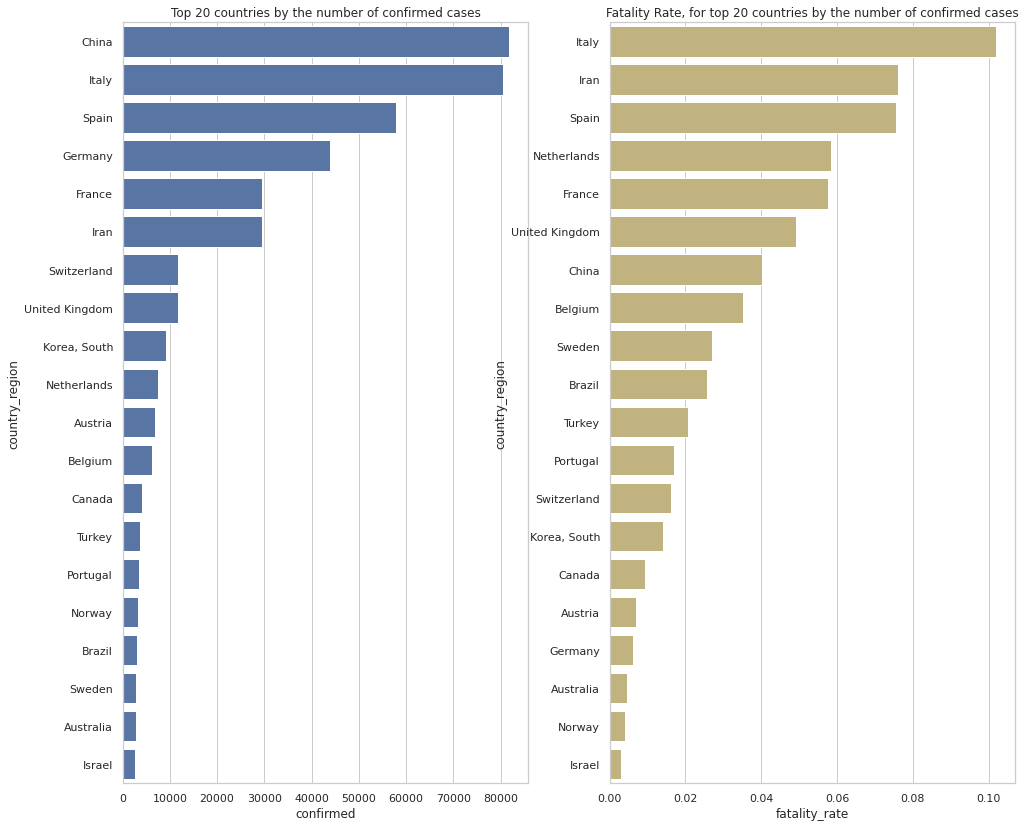

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df_fatal_rate = df_confirm.sort_values(by='fatality_rate', ascending=False)

# Initialize the matplotlib figure
f, (ax1, ax2) = plt.subplots(figsize=(16, 14), ncols=2)


sns.barplot(x="confirmed", y="country_region", data=df_confirm,
            label="confirmed", color="b",  ax=ax1)
ax1.set_title("Top 20 countries by the number of confirmed cases")

sns.barplot(x="fatality_rate", y="country_region", data=df_fatal_rate,
            label="fatality rate", color="y",  ax=ax2)
ax2.set_title("Fatality Rate, for top 20 countries by the number of confirmed cases")

In [0]:
import plotly.express as px

df['province_state'] = df['province_state'].fillna(df['country_region'])
fig = px.scatter_mapbox(data_frame=df, lat="latitude", lon="longitude", hover_data=["confirmed", "deaths"],  
                        size="confirmed", zoom=2, height=1000, hover_name="province_state" )
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [0]:
#!pip install bert-extractive_summarizer

In [0]:
from summarizer import Summarizer

body = 'Such a scandal as the prosecution of a brother for forgery—with a verdict of guilty—is a most truly horrible, deplorable, fatal thing. It takes the respectability out of a family perhaps at a critical moment, when the family is just assuming the robes of respectability: […] it is a black spot which all the soaps ever advertised could never wash off.'
body2 = 'Something else you want to summarize with BERT'
model = Summarizer()
print(model(body))
print(model(body2))


str ='''COVID-19 is a disease caused by a respiratory virus first identified in Wuhan, Hubei Province, China in December 2019. COVID-19 is a new virus that hasn't caused illness in humans before. Worldwide, COVID-19 has resulted in thousands of infections, 
causing illness and in some cases death. Cases have spread to countries throughout the world, with more cases reported daily.
'''

model=Summarizer()
abstract1_summary = model(str)

full_abstract = ''.join(abstract1_summary)
print(full_abstract)


Such a scandal as the prosecution of a brother for forgery—with a verdict of guilty—is a most truly horrible, deplorable, fatal thing.
Something else you want to summarize with BERT
COVID-19 is a disease caused by a respiratory virus first identified in Wuhan, Hubei Province, China in December 2019. COVID-19 is a new virus that hasn't caused illness in humans before.
